<div style="background-color: darkgreen; color: white; padding: 20px; text-align: center; font-size: 20px;">
  libraries
</div>

In [3]:
!pip install opencv-python numpy matplotlib

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

<div style="background-color: darkgreen; color: white; padding: 20px; text-align: center; font-size: 20px;">
  Solution Overview
</div>


<div style="background-color: darkgreen; color: white; padding: 20px; text-align: center; font-size: 20px;">
  Solution Implemention
</div>

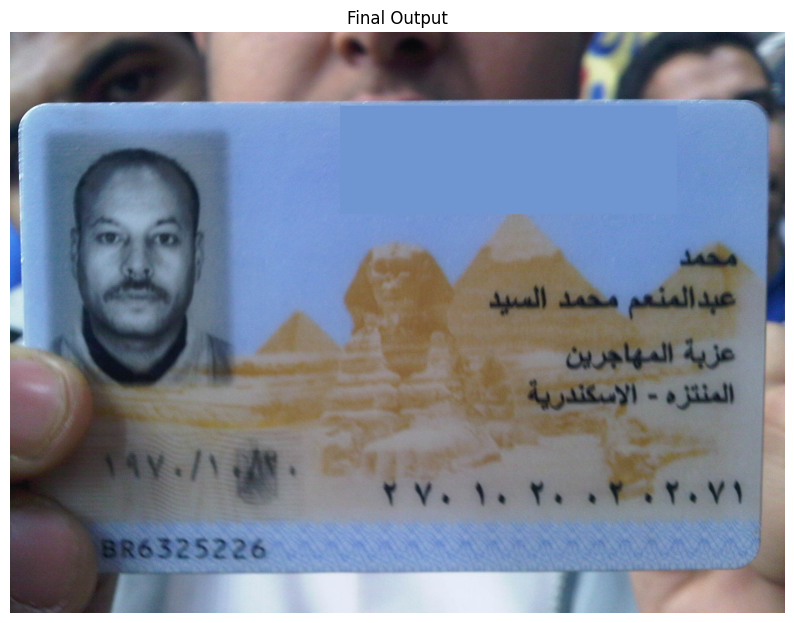

In [5]:
REFERENCE_IMAGE_PATH = 'reference_img.jpg'  # Fixed reference image path

def preprocess_image(image):
    """
    Preprocess the image by converting to grayscale, applying noise reduction,
    enhancing contrast, and normalizing.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_blurred = cv2.GaussianBlur(gray, (3, 3), 0)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    gray_clahe = clahe.apply(gray_blurred)
    normalized_img = cv2.normalize(gray_clahe, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    return normalized_img

def find_keypoints_and_descriptors(image):
    """
    Find keypoints and descriptors using SIFT feature detection.
    """
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return keypoints, descriptors

def find_matches(descriptors_img, descriptors_reference):
    """
    Find matches between descriptors using FLANN matcher.
    """
    flann = cv2.FlannBasedMatcher(dict(algorithm=1, trees=5), dict(checks=50))
    matches = flann.knnMatch(descriptors_img, descriptors_reference, k=2)
    good_matches = [m for m, n in matches if m.distance < 0.7 * n.distance]
    return good_matches

def find_homography_and_corners(keypoints_img, keypoints_reference, good_matches, reference_img):
    """
    Find homography matrix and corners based on keypoints and matches.
    """
    src_pts = np.float32([keypoints_img[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([keypoints_reference[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    M, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 3.0)
    h, w = reference_img.shape[:2]
    corners = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
    transformed_corners = cv2.perspectiveTransform(corners, M)
    return transformed_corners

def find_bounding_box(img):
    """
    Find the bounding box of the detected part in the image using feature matching
    with the fixed reference image.
    """
    reference_img = cv2.imread(REFERENCE_IMAGE_PATH)
    if reference_img is None:
        raise FileNotFoundError(f"Reference image not found at path: {REFERENCE_IMAGE_PATH}")

    processed_img = preprocess_image(img)
    processed_reference_img = preprocess_image(reference_img)

    keypoints_img, descriptors_img = find_keypoints_and_descriptors(processed_img)
    keypoints_reference, descriptors_reference = find_keypoints_and_descriptors(processed_reference_img)

    good_matches = find_matches(descriptors_img, descriptors_reference)

    transformed_corners = find_homography_and_corners(keypoints_img, keypoints_reference, good_matches, reference_img)

    x_min = max(0, np.min(transformed_corners[:, 0, 0]))
    y_min = max(0, np.min(transformed_corners[:, 0, 1]))
    x_max = min(img.shape[1] - 1, np.max(transformed_corners[:, 0, 0]))
    y_max = min(img.shape[0] - 1, np.max(transformed_corners[:, 0, 1]))

    return int(x_min), int(y_min), int(x_max), int(y_max)

def inpaint_detected_part(img, bbox):
    """
    Inpaint the detected part of the image with the average color of specific pixels
    within the bounding box.
    """
    x_min, y_min, x_max, y_max = bbox

    lower_left_pixel1 = img[y_max - 1, x_min]
    lower_left_pixel2 = img[y_max - 2, x_min]
    lower_right_pixel1 = img[y_max - 1, x_max]
    lower_right_pixel2 = img[y_max - 2, x_max]

    avg_color = np.uint8((np.array(lower_left_pixel1, dtype=np.uint16) + np.array(lower_left_pixel2, dtype=np.uint16) +
                          np.array(lower_right_pixel1, dtype=np.uint16) + np.array(lower_right_pixel2, dtype=np.uint16)) / 4)

    inpaint_mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
    cv2.rectangle(inpaint_mask, (x_min, y_min), (x_max, y_max), 255, -1)

    inpaint_result = img.copy()
    inpaint_result[inpaint_mask == 255] = avg_color

    return inpaint_result

def main(input_image_path, output_image_path):
    """
    Main function to process the input image, detect and inpaint the specified part,
    and save the output image.
    """
    img = cv2.imread(input_image_path)
    if img is None:
        raise FileNotFoundError(f"Input image not found at path: {input_image_path}")

    bbox = find_bounding_box(img)
    inpainted_img = inpaint_detected_part(img, bbox)

    cv2.imwrite(output_image_path, inpainted_img)

    # Display the inpainted image
    img_rgb = cv2.cvtColor(inpainted_img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 8))
    plt.imshow(img_rgb)
    plt.title('Final Output')
    plt.axis('off')
    plt.show()

# Example usage
input_image_path = '9.jpg'
output_image_path = 'output.jpg'
main(input_image_path, output_image_path)
